# PyTorch & MNIST Intro

Let's go through a simple example of Pytorch and MNIST as a way to level set NNs and the use of notebooks.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as pl
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

MNIST is probably the most traditionally used dataset for neural networks, as it is a relatively challenging problem in computer vision: recognizing single-digit numbers from a hand-written digital format. Classically, this dataset takes the form of samples of $28 \times 28$ matrices.

In [2]:
batch_size_train = 64
batch_size_test = 1000

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

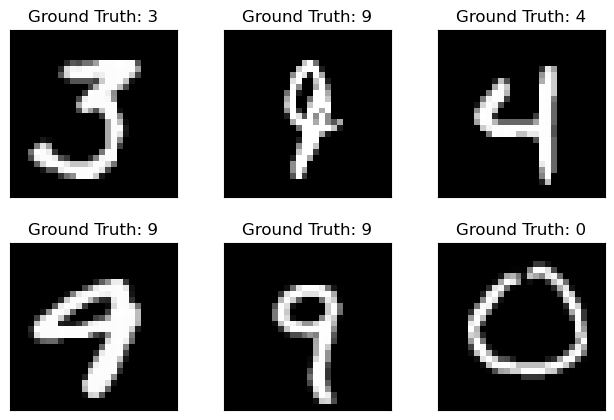

In [5]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Ground Truth: {}".format(example_targets[i]))
    pl.xticks([])
    pl.yticks([])
pl.show()

## Building the model

We need to specify the model through a Python class. Below we show how to create a Feedforward Neural Network model using Pytorch.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

You'll need to instantiate this class as well as an optimizer, which will apply an algorithm to find the internal parameters of that model, such as matrix weights and biases. As an example, we will use the Stochastic Gradient Descent algorithm.

In [8]:
learning_rate = 0.001
momentum = 0.1
log_interval = 10

In [9]:
network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training

Next, we will define the training procedure.

In [10]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
! mkdir -p results

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file results already exists.
Error occurred while processing: results.


In [12]:
def train(epoch, network):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

In [13]:
train(1, network)

C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.462653
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314634
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.172709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.038150
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.011766
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.793893
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.784094
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.759681
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.595977
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.612938
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.453784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.386518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.438524
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.395226
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.237686
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.228426
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.189160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.303519
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.156207
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.144378
Train Epoch: 1 [12800/60000 (

<br />
Alongside trainig, we will also monitor the performance of the model on a set of samples not seen during the training.

In [14]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [15]:
test()

C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
C:\Users\siddu\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5596, Accuracy: 8696/10000 (87%)



## Training and evaluating for multiple epochs

Let's train now for all desired epochs.

In [16]:
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch, network)
  test()

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.666574
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.541078


C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.564097
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.666229
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.488056
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.434858
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.543594
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.447622
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.549790
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.652385
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.670172
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.586397
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.554513
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.585009
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.654413
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.667827
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.639856
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.650934
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.545639
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.532475
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.734861
Train Epoch: 2 [13440/60000 (22%)]	Loss: 0.680402
Train Epoch: 2 [14080

# Model performance

Finally, we can inspect the results.

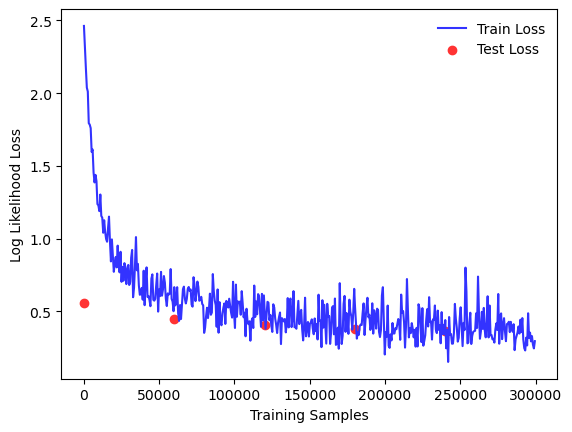

In [17]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's always important to inspect anecdotes to convince yourself the model is behind as expected.

In [18]:
with torch.no_grad():
  output = network(example_data.reshape(1000, 28*28))

C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


**Challenge:** Can you explain why we are using `torch.no_grad()`?

- We use torch.no_grad() when we don't need to calculate gradient in the background for backpropogation. Since we are just getting the output from the test data and not training the model, we use torch.no_grad() to avoid updating the model weights.

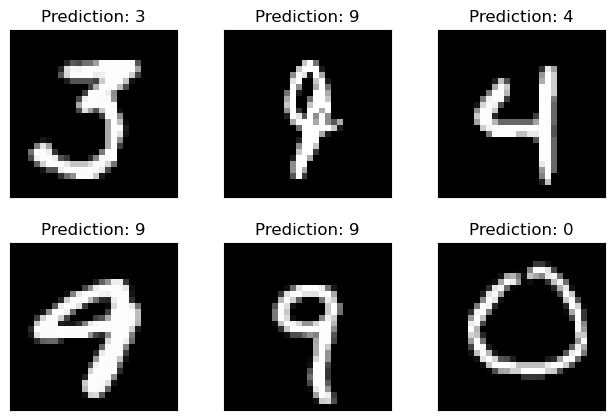

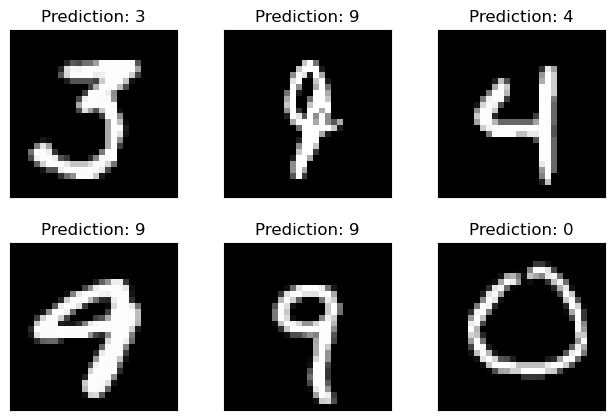

In [19]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
fig

**Challenge:** Re-do the plot above, but showcasing only miss-classifications (i.e. cases in which the model did wrong).

In [20]:
mismatch = (output.data.max(1, keepdim=True)[1].reshape([1, 1000])[0] != example_targets)
mismatch_labels = output.data.max(1, keepdim=True)[1].reshape([1, 1000])[0][mismatch][:6]
mismatch_example = example_data[mismatch][:6]


In [21]:
mismatch_labels

tensor([6, 4, 6, 9, 7, 2])

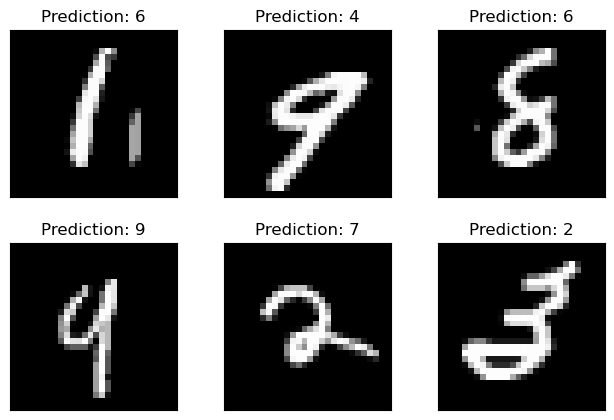

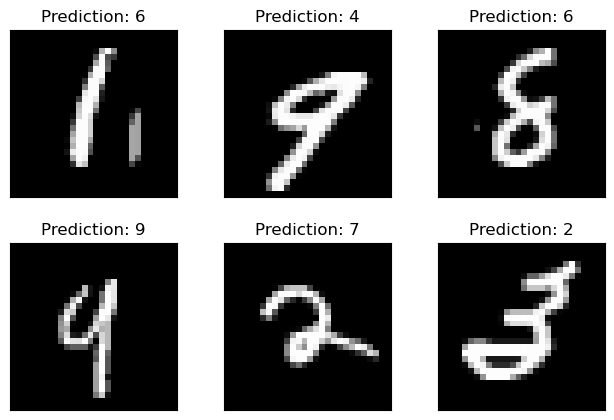

In [22]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2, 3, i + 1)
    pl.tight_layout()
    pl.imshow(mismatch_example[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(mismatch_labels[i].item()))
    pl.xticks([])
    pl.yticks([])

fig

## Loading trained models

Eventually, you will want to load the model you trained in the past for either running inference or continue the training procedure. The functions we developed above save artifacts contain all of the metadata and data about the model, assuming you have the right model class. Let's inspect those files: 

In [23]:
! ls results

model_iteration-1.pth
model_iteration-2.pth
model_iteration-3.pth
model_iteration-4.pth
model_iteration-5.pth
optimizer_iteration-1.pth
optimizer_iteration-2.pth
optimizer_iteration-3.pth
optimizer_iteration-4.pth
optimizer_iteration-5.pth


To load a model:

In [24]:
trained_model = FeedforwardNeuralNetModel()
model_state_dict = torch.load("results/model_iteration-1.pth")
trained_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Before proceeding, let's inspect `model_state_dict`

In [25]:
model_state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias'])

In [26]:
model_state_dict['fc1.weight'].shape

torch.Size([10, 784])

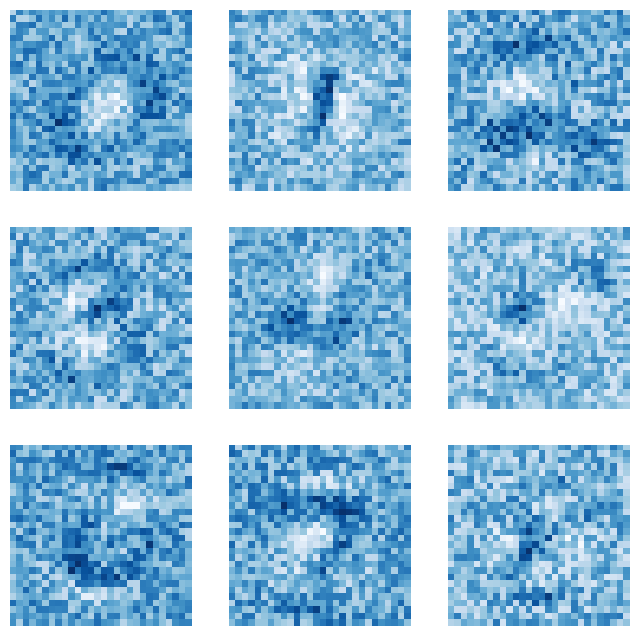

In [27]:
f,axs = pl.subplots(3,3, figsize=(8,8))

c = 0
for ax in axs:
    for sax in ax:
        sax.imshow(model_state_dict['fc1.weight'][c].reshape((28,28)), 
                   cmap = pl.get_cmap('Blues'))
        c += 1
        sax.axis('off')

pl.show()

Let's do the same for the optimizer

In [28]:
optimizer = optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_state_dict = torch.load("results/optimizer_iteration-3.pth")
optimizer.load_state_dict(optimizer_state_dict)

In [29]:
optimizer_state_dict.keys()

dict_keys(['state', 'param_groups'])

**Challenge:** Can you make sense of the data in this dictionary?

- 'state' key has the values regarding the background values of the optimizer such as the gradients.
- 'param_groups' has the parameters of the optimizer such as the learning rate and momentum.

## Final challenges

* What happens if you use only 10% of the available training data? Plot the difference in performance of the network.
* What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?
* What happens if you change parameters like the learnign rate and momentum? Plot the difference.
* Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?
* Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?
* [stretch] Can you change this model and turn it into a convolutional neural network?

## Challenge 1 ##

In [30]:
def train(epoch, network, train_loader, optimizer, log_interval, loss_lst):
        network.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = network(data.view(-1, 28*28))
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if batch_idx % log_interval == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        loss_lst.append(train_loss / len(train_loader.dataset))

def test(network, test_loader, loss_lst):
        network.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = network(data.view(-1, 28*28))
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        loss_lst.append(test_loss)
        print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [31]:
train_data_10_percent = torch.utils.data.Subset(train_loader.dataset, range(int(len(train_loader.dataset) * 0.1)))
train_loader_10_percent = torch.utils.data.DataLoader(dataset=train_data_10_percent, batch_size=batch_size_train, shuffle=True)
train_losses_10_percent = []
train_losses_full = []
test_losses = []

In [32]:
network_10_percent = FeedforwardNeuralNetModel()
optimizer_10_percent = optim.SGD(network_10_percent.parameters(), lr=learning_rate, momentum=momentum)
network_full = FeedforwardNeuralNetModel()
optimizer_full = optim.SGD(network_full.parameters(), lr=learning_rate, momentum=momentum)

In [33]:
for epoch in range(1, 6): 
    train(epoch, network_10_percent, train_loader_10_percent, optimizer_10_percent, log_interval, train_losses_10_percent)


C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/6000 (0%)]	Loss: 2.472538
Train Epoch: 1 [640/6000 (11%)]	Loss: 2.092759
Train Epoch: 1 [1280/6000 (21%)]	Loss: 2.045848
Train Epoch: 1 [1920/6000 (32%)]	Loss: 1.995059
Train Epoch: 1 [2560/6000 (43%)]	Loss: 1.883918
Train Epoch: 1 [3200/6000 (53%)]	Loss: 1.692624
Train Epoch: 1 [3840/6000 (64%)]	Loss: 1.664274
Train Epoch: 1 [4480/6000 (74%)]	Loss: 1.621138
Train Epoch: 1 [5120/6000 (85%)]	Loss: 1.469161
Train Epoch: 1 [5760/6000 (96%)]	Loss: 1.487101
Train Epoch: 2 [0/6000 (0%)]	Loss: 1.506710
Train Epoch: 2 [640/6000 (11%)]	Loss: 1.392102
Train Epoch: 2 [1280/6000 (21%)]	Loss: 1.292386
Train Epoch: 2 [1920/6000 (32%)]	Loss: 1.319497
Train Epoch: 2 [2560/6000 (43%)]	Loss: 1.128795
Train Epoch: 2 [3200/6000 (53%)]	Loss: 1.215898
Train Epoch: 2 [3840/6000 (64%)]	Loss: 1.106416
Train Epoch: 2 [4480/6000 (74%)]	Loss: 1.057016
Train Epoch: 2 [5120/6000 (85%)]	Loss: 1.069672
Train Epoch: 2 [5760/6000 (96%)]	Loss: 1.079658
Train Epoch: 3 [0/6000 (0%)]	Loss: 1.036136
Train 

In [34]:
for epoch in range(1, 6):
    train(epoch, network_full, train_loader, optimizer_full, log_interval, train_losses_full)

C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.589556
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.340764
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.064073
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.107391
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.940965
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.812450
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.712466
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.621950
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.706449
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.475927
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.452131
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.488790
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.374091
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.381625
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.414379
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.333127
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.198524
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.271147
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.301459
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.207279
Train Epoch: 1 [12800/60000 (

In [35]:
train_losses_10_percent

[0.028796058237552644,
 0.01983638068040212,
 0.015727343410253523,
 0.0134519026974837,
 0.011989882131417592]

In [36]:
train_losses_full

[0.014688171982765197,
 0.008180707888801892,
 0.007041451971977949,
 0.006490226897845666,
 0.006148999314258496]

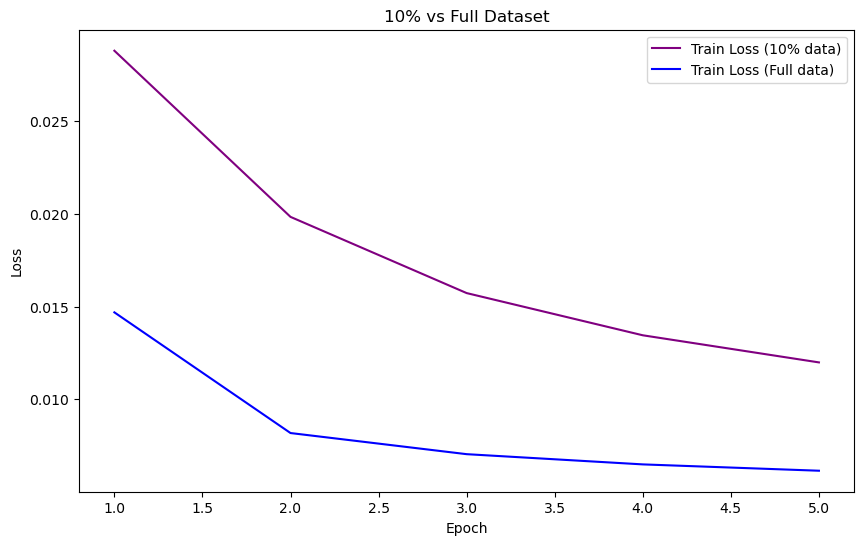

In [37]:
pl.figure(figsize=(10, 6))
pl.plot(range(1, 6), train_losses_10_percent, label='Train Loss (10% data)', color='purple')
pl.plot(range(1, 6), train_losses_full, label='Train Loss (Full data)', color='blue')
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.title('10% vs Full Dataset')
pl.legend()
pl.show()

## Answer: ##
- The accuracy decreases with the decrease in the train set size.

## Challenge 2 ##

In [38]:
import numpy as np

In [39]:
targets = train_loader.dataset.targets
labels = np.array(targets)

In [40]:
idx_5 = np.where(labels == 5)[0]
idx_5

array([    0,    11,    35, ..., 59968, 59993, 59997], dtype=int64)

In [41]:
indices_80 = np.random.choice(idx_5, int(0.8 * (len(idx_5))), replace=False)
idx_all = np.concatenate([np.where(labels != 5)[0], indices_80])
idx_all

array([    1,     2,     3, ..., 28846, 18083,  9033], dtype=int64)

In [42]:
train_data_80_5 = torch.utils.data.Subset(train_loader.dataset, idx_all)
train_loader_80_5 = torch.utils.data.DataLoader(dataset=train_data_80_5, batch_size=batch_size_train, shuffle=True)
network_80_5 = FeedforwardNeuralNetModel()
optimizer_80_5 = optim.SGD(network_80_5.parameters(), lr=learning_rate, momentum=momentum)
train_losses_80_5 = []
test_losses_80_5 = []

In [43]:
for epoch in range(1, 6):
    train(epoch, network_80_5, train_loader_80_5, optimizer_80_5, log_interval, train_losses_80_5)
    test(network_80_5, test_loader, test_losses_80_5)

C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/58915 (0%)]	Loss: 2.546990
Train Epoch: 1 [640/58915 (1%)]	Loss: 2.455407
Train Epoch: 1 [1280/58915 (2%)]	Loss: 2.296343
Train Epoch: 1 [1920/58915 (3%)]	Loss: 2.208586
Train Epoch: 1 [2560/58915 (4%)]	Loss: 1.995211
Train Epoch: 1 [3200/58915 (5%)]	Loss: 2.067283
Train Epoch: 1 [3840/58915 (7%)]	Loss: 1.876025
Train Epoch: 1 [4480/58915 (8%)]	Loss: 1.743013
Train Epoch: 1 [5120/58915 (9%)]	Loss: 1.710271
Train Epoch: 1 [5760/58915 (10%)]	Loss: 1.606961
Train Epoch: 1 [6400/58915 (11%)]	Loss: 1.511296
Train Epoch: 1 [7040/58915 (12%)]	Loss: 1.510288
Train Epoch: 1 [7680/58915 (13%)]	Loss: 1.461865
Train Epoch: 1 [8320/58915 (14%)]	Loss: 1.312788
Train Epoch: 1 [8960/58915 (15%)]	Loss: 1.360298
Train Epoch: 1 [9600/58915 (16%)]	Loss: 1.301900
Train Epoch: 1 [10240/58915 (17%)]	Loss: 1.232958
Train Epoch: 1 [10880/58915 (18%)]	Loss: 1.435488
Train Epoch: 1 [11520/58915 (20%)]	Loss: 1.163912
Train Epoch: 1 [12160/58915 (21%)]	Loss: 1.225200
Train Epoch: 1 [12800/58915 (

In [44]:
for epoch in range(1, 6):
    train(epoch, network_full, train_loader, optimizer_full, log_interval, train_losses_full)
    test(network_full, test_loader, test_losses)
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.350681
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.402402


C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.300496
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.651740
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.606013
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.556523
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.281246
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.310378
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.345308
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.414900
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.650204
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.355549
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.522847
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.437609
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.354652
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.350534
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.589593
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.415829
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.240318
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.152730
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.515602
Train Epoch: 1 [13440/60000 (22%)]	Loss: 0.325118
Train Epoch: 1 [14080

In [45]:
test_losses_80_5

[0.5750653015136719,
 0.4587682525634766,
 0.4135638061523437,
 0.3879333465576172,
 0.36989661560058595]

In [46]:
test_losses

[0.3556050842285156,
 0.34636712646484374,
 0.33887917785644533,
 0.33300447692871094,
 0.3275403747558594]

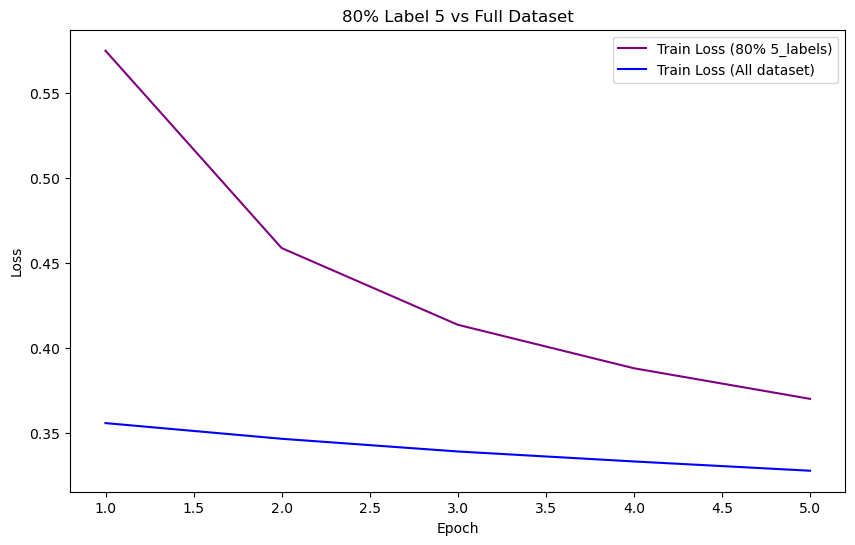

In [47]:
pl.figure(figsize=(10, 6))
pl.plot(range(1, 6), test_losses_80_5, label='Train Loss (80% 5_labels)', color='purple')
pl.plot(range(1, 6), test_losses, label='Train Loss (All dataset)', color='blue')
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.title('80% Label 5 vs Full Dataset')
pl.legend()
pl.show()

## Answer: ##
- Removing 20% of the training set with the labels '5' would decrease the overall performance of the model.
- I think this difference is homogenous as it would reduce the accuracy for predicting not just label 5 but also the rest of the labels.

## Challenge 3

In [48]:
lr1 = 0.001
m1 = 0.1
lr2 = 0.01
m2 = 0.05
lr3 = 0.0001
m3 = 0.2

In [49]:
network_c3_1 = FeedforwardNeuralNetModel()
network_c3_2 = FeedforwardNeuralNetModel()
network_c3_3 = FeedforwardNeuralNetModel()

In [50]:
loss_lst_c3_1 = []
loss_lst_c3_2 = []
loss_lst_c3_3 = []

In [51]:
optimizer_c3_1 = optim.SGD(network.parameters(), lr=lr1, momentum=m1)
optimizer_c3_2 = optim.SGD(network.parameters(), lr=lr2, momentum=m2)
optimizer_c3_3 = optim.SGD(network.parameters(), lr=lr3, momentum=m3)

In [52]:
for epoch in range(1, 6):
    train(epoch, network_c3_1, train_loader, optimizer_c3_1, log_interval, loss_lst_c3_1)

C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.419130
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.647347
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.554750
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.531397
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.494683
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.534682
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.584121
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.556049
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.505915
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.393511
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.444617
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.587931
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.453004
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.427904
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.495999
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.594623
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.490297
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.610167
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.541726
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.362676
Train Epoch: 1 [12800/60000 (

In [53]:
for epoch in range(1, 6):
    train(epoch, network_c3_2, train_loader, optimizer_c3_2, log_interval, loss_lst_c3_2)

C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.655894
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.592981
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.393290
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.488302
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.509224
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.492355
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.599701
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.602165
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.326831
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.460164
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.505498
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.595804
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.533200
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.595063
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.464190
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.409201
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.687799
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.537226
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.525834
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.534724
Train Epoch: 1 [12800/60000 (

In [54]:
for epoch in range(1, 6):
    train(epoch, network_c3_3, train_loader, optimizer_c3_3, log_interval, loss_lst_c3_3)

C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.540405
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.442615
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.477357
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.505151
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.515902
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.463409
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.475003
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.497179
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.555008
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.574922
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.496835
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.601663
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.486006
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.525643
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.516856
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.531893
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.571954
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.567677
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.475118
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.544122
Train Epoch: 1 [12800/60000 (

In [55]:
lr1, m1, lr2, m2, lr3, m3

(0.001, 0.1, 0.01, 0.05, 0.0001, 0.2)

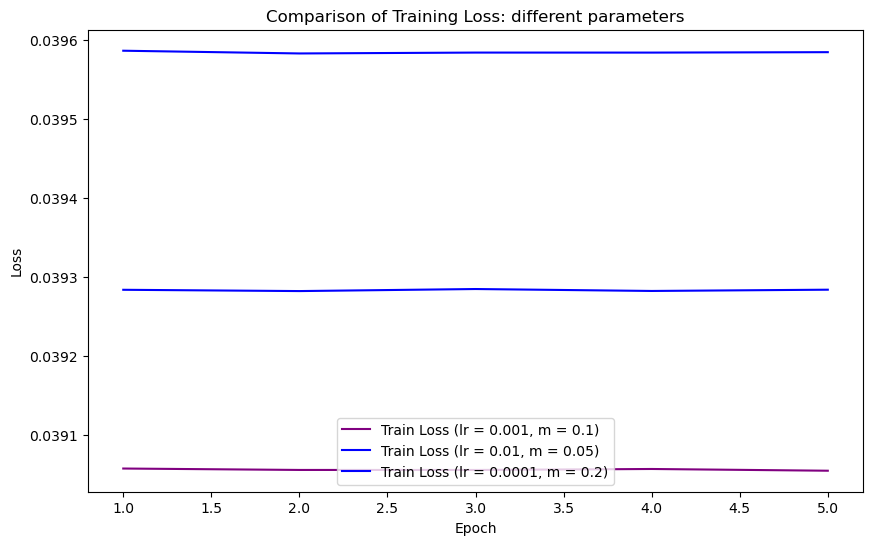

In [56]:
pl.figure(figsize=(10, 6))
pl.plot(range(1, 6), loss_lst_c3_1, label='Train Loss (lr = 0.001, m = 0.1)', color='purple')
pl.plot(range(1, 6), loss_lst_c3_2, label='Train Loss (lr = 0.01, m = 0.05)', color='blue')
pl.plot(range(1, 6), loss_lst_c3_3, label='Train Loss (lr = 0.0001, m = 0.2)', color='blue')
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.title('Comparison of Training Loss: different parameters')
pl.legend()
pl.show()

## Challenge 4 ##

In [57]:
class FeedforwardNeuralNetModel_c4(nn.Module):
    def __init__(self):
        input_dim = 28*28
        hidden_dim = 128
        num_classes = 10
        super(FeedforwardNeuralNetModel_c4, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, num_classes) 

    def forward(self, x):
        out = self.fc2(F.relu(self.fc1(x)))
        return F.log_softmax(out)

In [58]:
network_c4 = FeedforwardNeuralNetModel_c4()
optimizer_c4 = optim.SGD(network_c4.parameters(), lr = learning_rate, momentum = momentum)
loss_lst_c4 = []
test_losses_c4 = []
network_full = FeedforwardNeuralNetModel()
optimizer_full = optim.SGD(network_full.parameters(), lr = learning_rate, momentum = momentum)
loss_lst_full = []
test_losses_full = []

In [59]:
for epoch in range(1, 10):
    train(epoch, network_full, train_loader, optimizer_full, log_interval, loss_lst_full)


C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.502811
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.416082
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.233305
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.086179
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.925654
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.943818
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.834920
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.822891
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.657596
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.517303
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.534658
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.479194
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.347329
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.520235
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.368195
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.346861
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.256963
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.247771
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.360282
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.221629
Train Epoch: 1 [12800/60000 (

In [60]:
for epoch in range(1, 10):
    train(epoch, network_c4, train_loader, optimizer_c4, log_interval, loss_lst_c4)


C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\1605406139.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.350133
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.347260
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.287742
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.280524
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.273475
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240905
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.235950
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.238748
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.226207
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.184694
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.165497
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.185294
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.085767
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.107210
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.070799
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.116843
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.059446
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.048908
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.059248
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.956392
Train Epoch: 1 [12800/60000 (

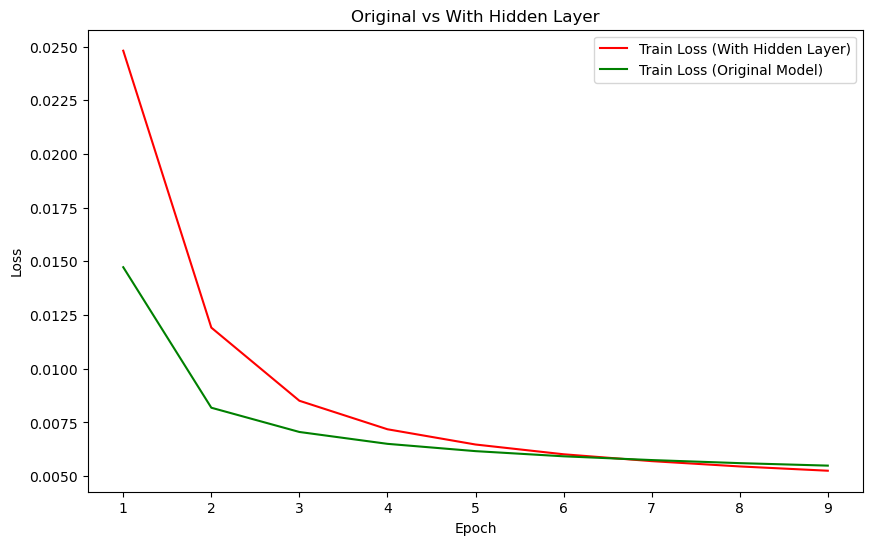

In [61]:
pl.figure(figsize=(10, 6))
pl.plot(range(1, 10), loss_lst_c4, label='Train Loss (With Hidden Layer)', color='red')
pl.plot(range(1, 10), loss_lst_full, label='Train Loss (Original Model)', color='green')
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.title('Original vs With Hidden Layer')
pl.legend()
pl.show()

In [62]:
loss_lst_c4

[0.024808066749572755,
 0.01191479955414931,
 0.008509855741262435,
 0.007182522739718358,
 0.0064725076968471205,
 0.006017878787219525,
 0.005698660795887311,
 0.005451743328819672,
 0.005252168891082208]

In [63]:
loss_lst_full

[0.014728118316332499,
 0.008185520552595457,
 0.007056265451014042,
 0.006503926505148411,
 0.006164059963574012,
 0.005923442691812913,
 0.0057485129815836745,
 0.005605316312611103,
 0.005489425038297971]

## Answer ##
- Adding a hidden layer initially worsened the performance, but when I increased the training epochs to 10, it started performing better at around epoch 7.
- I would assume that the hidden layer would perform even better on the test data as it would generalize the data better.

## Challenge 5 ##

In [64]:
network_l2 = FeedforwardNeuralNetModel_c4()
optimizer_l2 = optim.SGD(network_l2.parameters(), lr=learning_rate, momentum=momentum, weight_decay=0.01)
loss_lst_l2 = []

In [65]:
for epoch in range(1, 10):
    train(epoch, network_l2, train_loader, optimizer_l2, log_interval, loss_lst_l2)


C:\Users\siddu\AppData\Local\Temp\ipykernel_37492\1605406139.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331378
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.390510
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.338596
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.285726
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.296237
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.306239
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.216870
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.253837
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.184608
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.231452
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.151636
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.128551
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.139971
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.127270
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.097983
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.064597
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.066415
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.059797
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.035842
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.999650
Train Epoch: 1 [12800/60000 (

In [66]:
loss_lst_full

[0.014728118316332499,
 0.008185520552595457,
 0.007056265451014042,
 0.006503926505148411,
 0.006164059963574012,
 0.005923442691812913,
 0.0057485129815836745,
 0.005605316312611103,
 0.005489425038297971]

In [67]:
loss_lst_l2

[0.024592393336693445,
 0.011788122378786405,
 0.008586230330169201,
 0.007306272475421429,
 0.006610105087359746,
 0.006166812463353078,
 0.005851540788759788,
 0.0056117837419112524,
 0.005423810347169638]

In [68]:
test_losses_full

[]

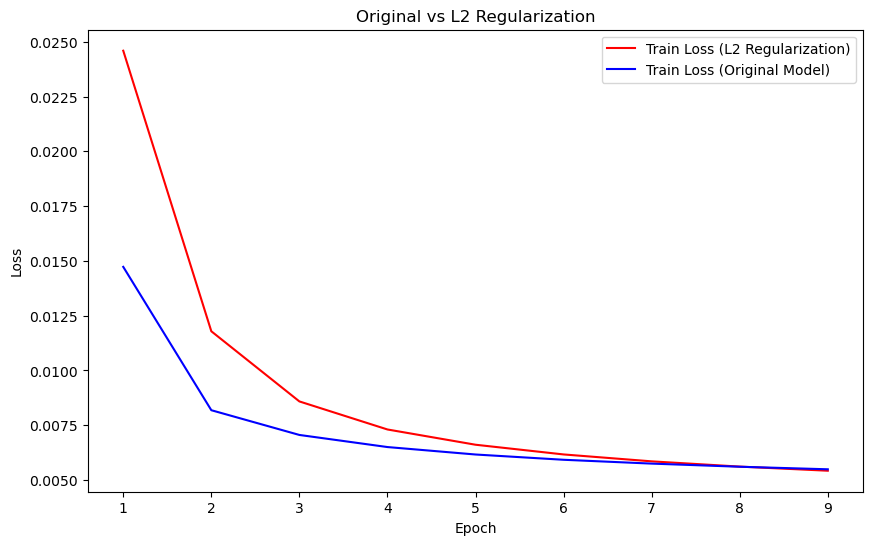

In [69]:
pl.figure(figsize=(10, 6))
pl.plot(range(1, 10), loss_lst_l2, label='Train Loss (L2 Regularization)', color='red')
pl.plot(range(1, 10), loss_lst_full, label='Train Loss (Original Model)', color='blue')
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.title('Original vs L2 Regularization')
pl.legend()
pl.show()

In [70]:
class FeedforwardNeuralNetModel_Dropout(nn.Module):
    def __init__(self):
        super(FeedforwardNeuralNetModel_Dropout, self).__init__()
        input_dim = 28 * 28
        hidden_dim = 128
        output_dim = 10
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.fc2(self.dropout(F.relu(self.fc1(x))))
        return F.log_softmax(x, dim=1)

In [71]:
network_dropout = FeedforwardNeuralNetModel_Dropout()
optimizer_dropout = optim.SGD(network_dropout.parameters(), lr=learning_rate, momentum=momentum)
loss_lst_dropout = []

In [72]:
for epoch in range(1, 10):
    train(epoch, network_dropout, train_loader, optimizer_dropout, log_interval, loss_lst_dropout)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.350304
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.381827
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.368263
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.333606
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.268132
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.318280
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.283787
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.274195
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.266157
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.247497
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.228110
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.193428
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.185145
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.199733
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.131956
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.143567
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.099992
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.170514
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.146000
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.047647
Train Epoch: 1 [12800/60000 (

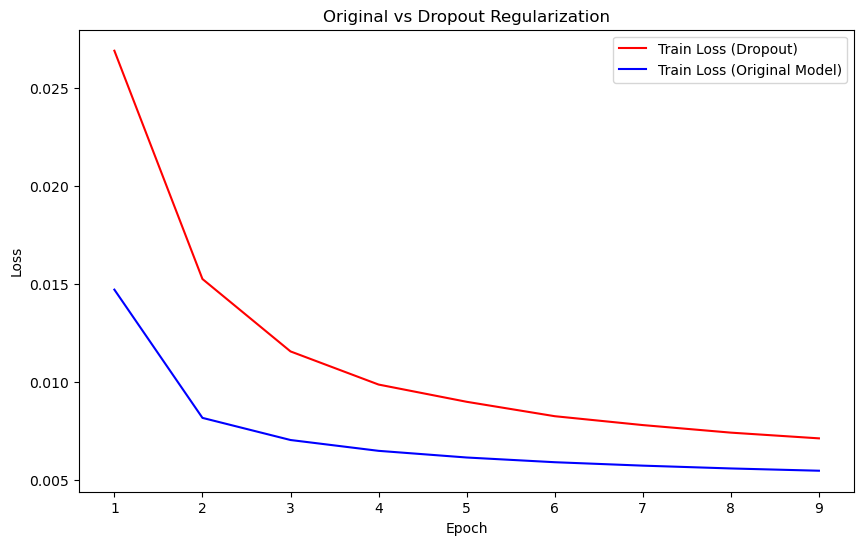

In [73]:
pl.figure(figsize=(10, 6))
pl.plot(range(1, 10), loss_lst_dropout, label='Train Loss (Dropout)', color='red')
pl.plot(range(1, 10), loss_lst_full, label='Train Loss (Original Model)', color='blue')
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.title('Original vs Dropout Regularization')
pl.legend()
pl.show()

## Challenge 6

In [74]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [75]:
network_cnn = CNN()
optimizer_cnn = optim.SGD(network_cnn.parameters(), lr=learning_rate, momentum=momentum)
loss_lst_cnn = []

In [76]:
def train_cnn(epoch, network, train_loader, optimizer, log_interval, loss_lst):
    network.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    loss_lst.append(train_loss / len(train_loader.dataset))

In [77]:
for epoch in range(1, 10):
    train_cnn(epoch, network_cnn, train_loader, optimizer_cnn, log_interval, loss_lst_cnn)

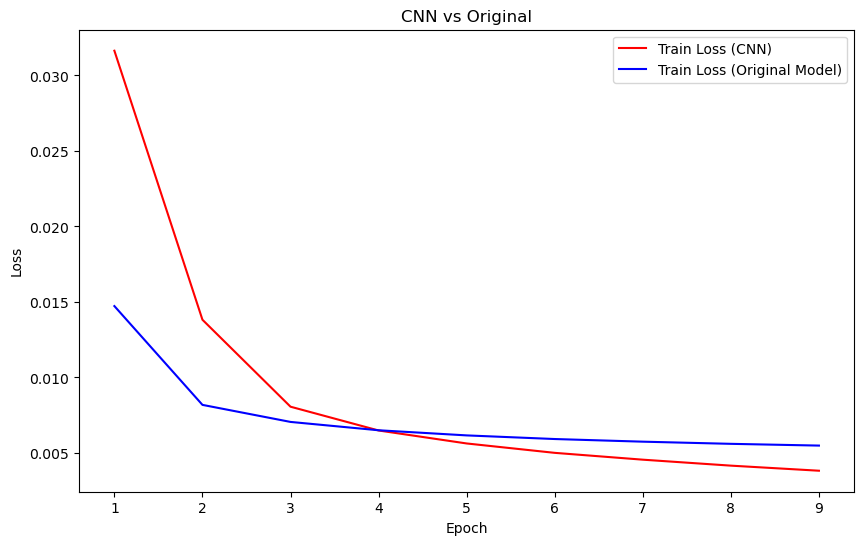

In [78]:
pl.figure(figsize=(10, 6))
pl.plot(range(1, 10), loss_lst_cnn, label='Train Loss (CNN)', color='red')
pl.plot(range(1, 10), loss_lst_full, label='Train Loss (Original Model)', color='blue')
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.title('CNN vs Original')
pl.legend()
pl.show()